In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tqdm
import itertools

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.utils import *

import librosa, librosa.display

In [0]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [0]:
label = pd.read_csv('drive/My Drive/10_Predictive/Pmd_for_Hydro_Plant/data/1_Generator_Stator/5_post_pocessing/classification_label/label_5.csv')
label.index = label['id']
label.drop(('id'), axis=1, inplace=True)
label.columns = ['datetime','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10',
                 's11','s12','s13','s14','s15','s16','s17','s18','s19','s20',
                 's21','s22','s23','s24','s25','s26','s27']

df = pd.read_csv('drive/My Drive/10_Predictive/Pmd_for_Hydro_Plant/data/1_Generator_Stator/5_post_pocessing/input/INPUT.csv')
df.index = df['id']
df.drop(('id'), axis=1, inplace=True)

df_concat = pd.concat([df, label], axis=1, sort=False)
df_concat.dropna(inplace=True)

df = df_concat.iloc[:,:31]
label = df_concat.iloc[:,31:]

In [34]:
print(df.shape[0]%600)
part = df.shape[0]%600
df = df.iloc[part:,:]
label = label.iloc[part:,:]
print(df.shape)

484
(141000, 31)


In [35]:
df = df.iloc[:,1:].values.reshape(-1,600,30).transpose(0,1,2)
print(df.shape)
label = label.iloc[:,1:].values.reshape(-1,600,27).transpose(0,1,2)
label = np.max(label, axis = 1)
label = pd.DataFrame(label,columns=["s1", "s2", "s3", "s4", "s5", "s6", "s7", "s8", "s9", "s10", "s11", "s12", "s13","s14",
                             "s15", "s16", "s17", "s18", "s19", "s20", "s21", "s22", "s23", "s24", "s25", "s26", "s27"])
print(label.shape)

(235, 600, 30)
(235, 27)


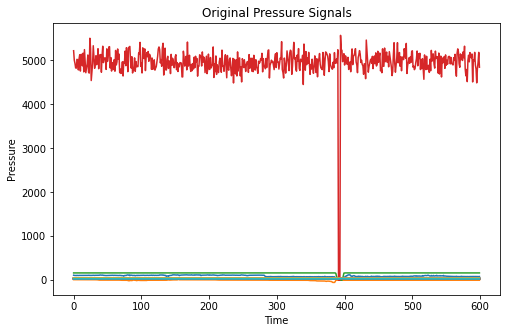

In [36]:
### PLOT ORIGINAL PRESSURE DATA ###

plt.figure(figsize=(8,5))
plt.plot(df[2])
plt.title('Original Pressure Signals')
plt.ylabel('Pressure'); plt.xlabel('Time')
np.set_printoptions(False)

In [37]:
### APPLY CLIPPING AND FIRST ORDER DIFFERECE ###

df = np.clip(np.diff(df, axis=1), -5,5)
df.shape

(235, 599, 30)

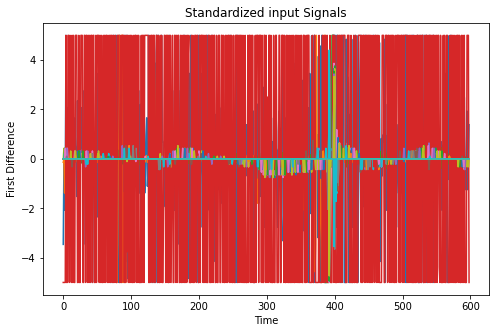

In [38]:
### PLOT STANDARDIZED DATA ###

plt.figure(figsize=(8,5))
plt.plot(df[2])
plt.title('Standardized input Signals')
plt.ylabel('First Difference'); plt.xlabel('Time')
np.set_printoptions(False)

In [39]:
### LABEL DISTRIBUTION ###

label = label.s14
label.value_counts()

0.0    205
1.0     30
Name: s14, dtype: int64

In [40]:
### MAPPING LABEL ###

diz_label, diz_reverse_label = {}, {}
for i,lab in enumerate(label.unique()):
    diz_label[lab] = i
    diz_reverse_label[i] = lab

print(diz_label)
print(diz_reverse_label)
label = label.map(diz_label)
y = to_categorical(label)

{0.0: 0, 1.0: 1}
{0: 0.0, 1: 1.0}


In [41]:
### APPLY SPECTROGRAM TRANSFORMATION FOR EACH PRESSURE SIGNAL ###

df_spectre = []

for i,sample in enumerate(tqdm.tqdm(df)):
    
    sample_spectre = np.apply_along_axis(lambda x: librosa.feature.melspectrogram(x,sr=40000) ,0, sample)
    df_spectre.append(sample_spectre)
    
df_spectre = np.asarray(df_spectre)
df_spectre.shape

100%|██████████| 235/235 [00:40<00:00,  5.75it/s]


(235, 128, 2, 30)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


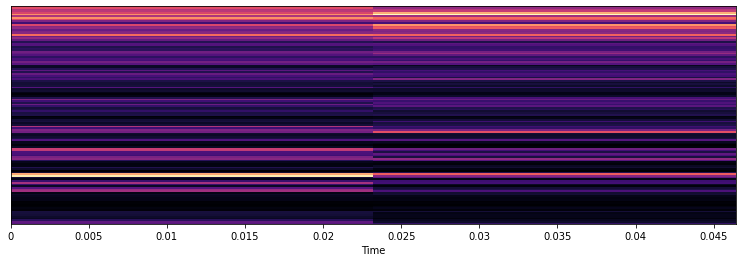

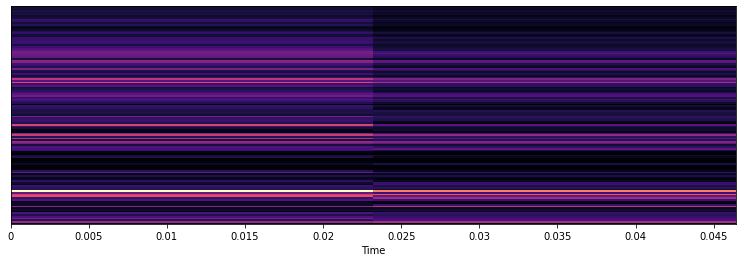

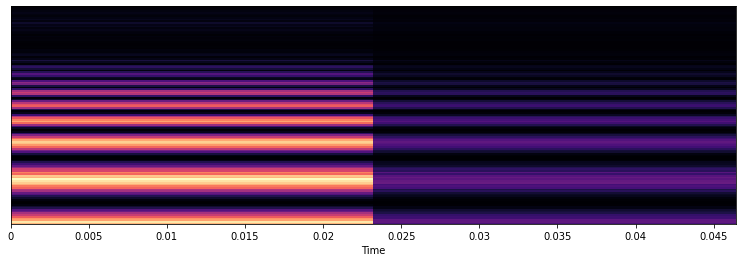

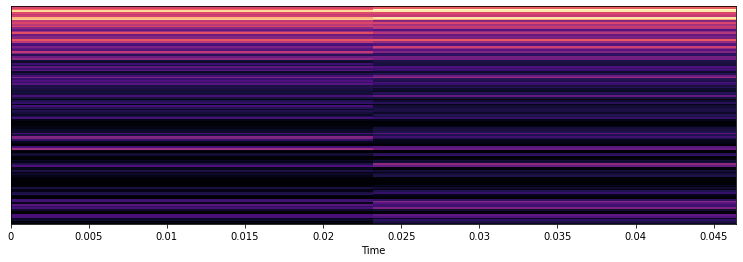

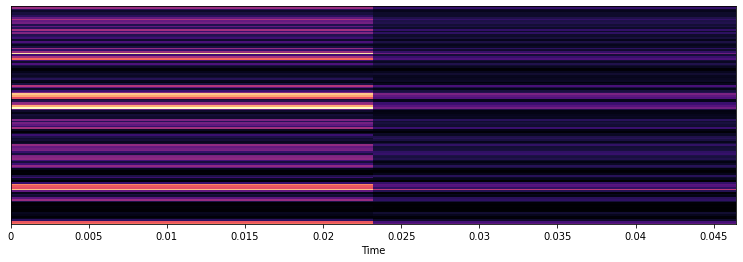

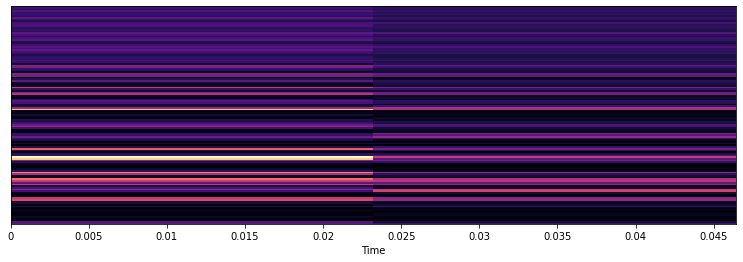

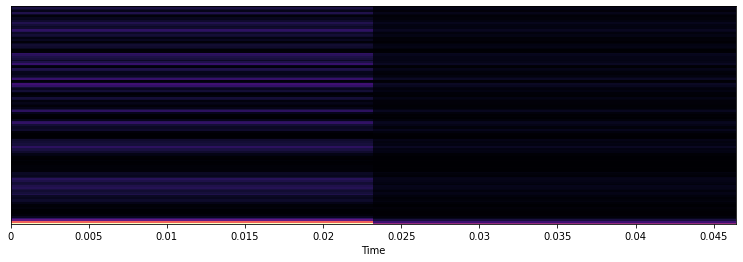

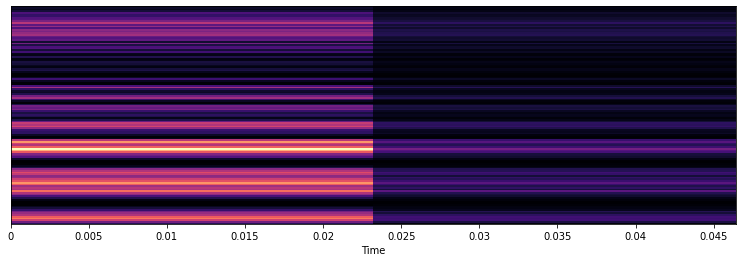

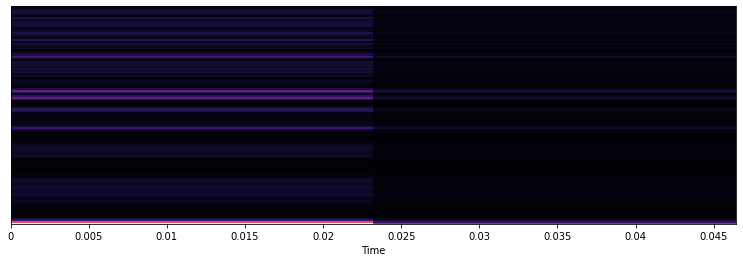

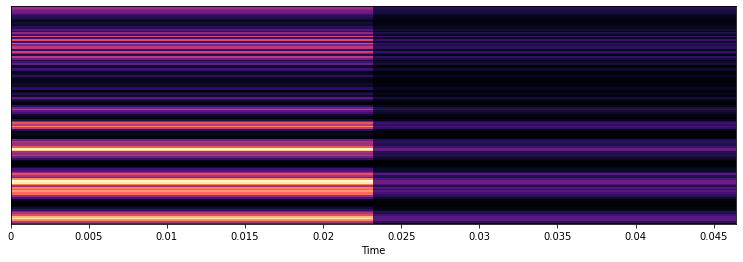

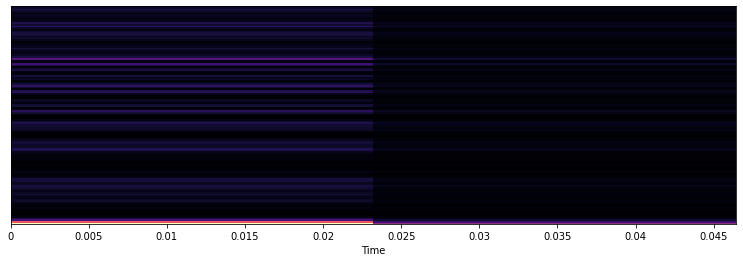

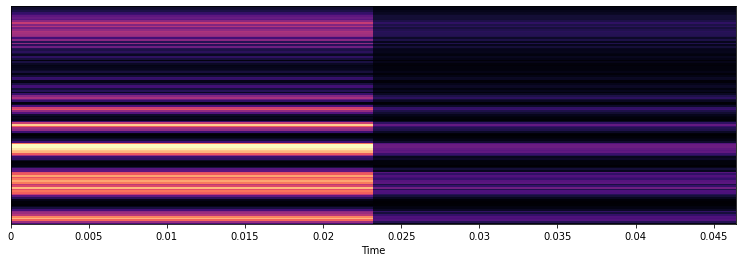

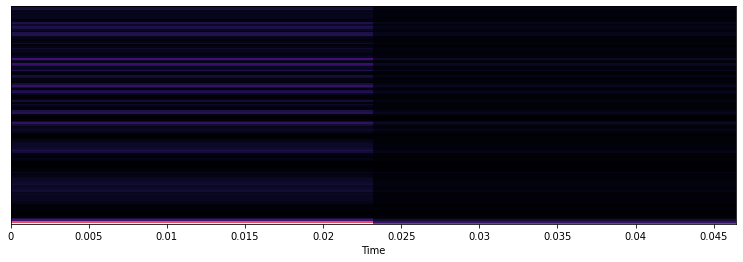

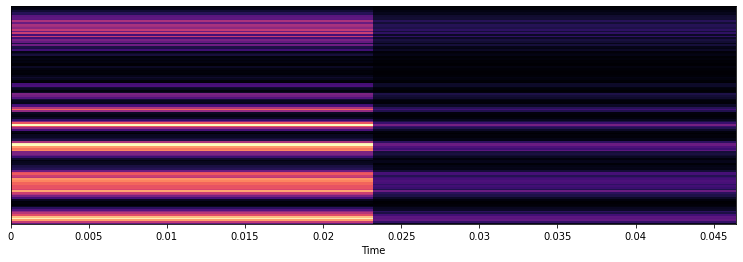

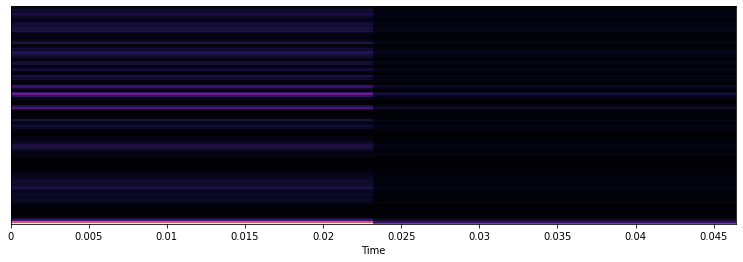

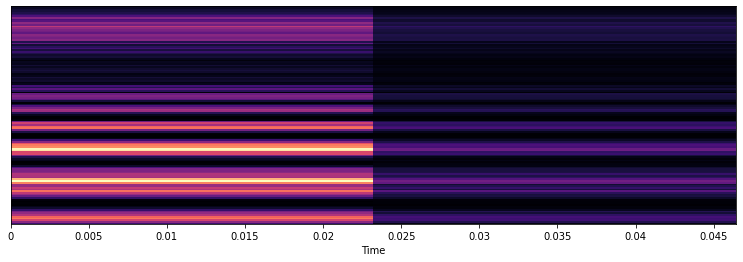

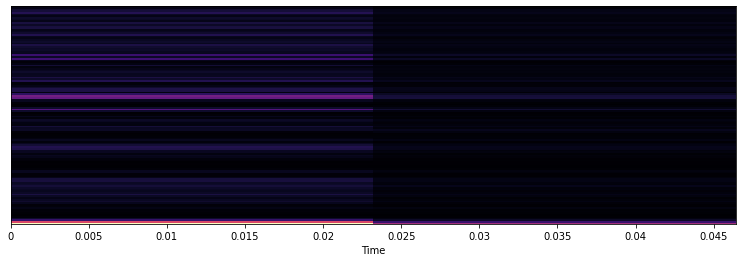

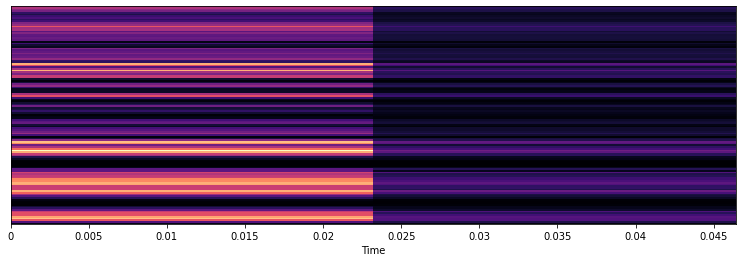

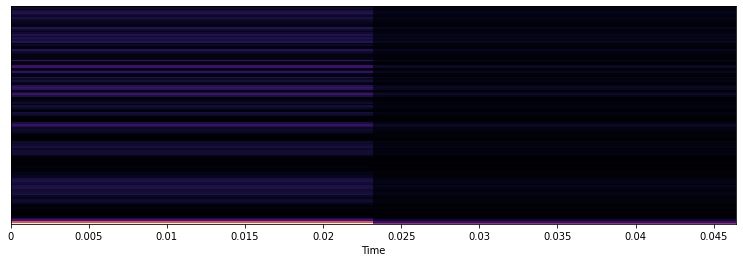

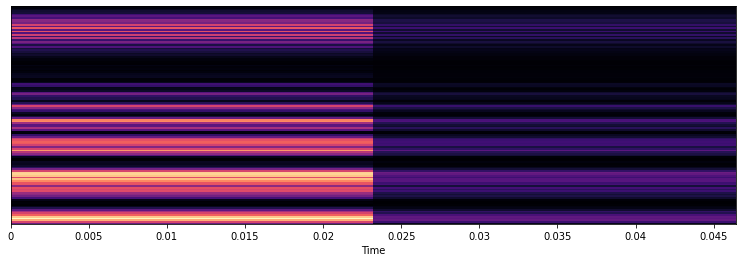

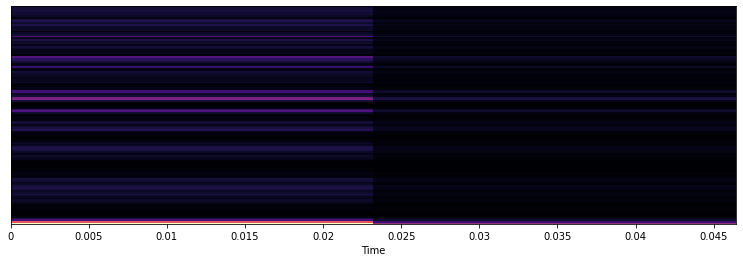

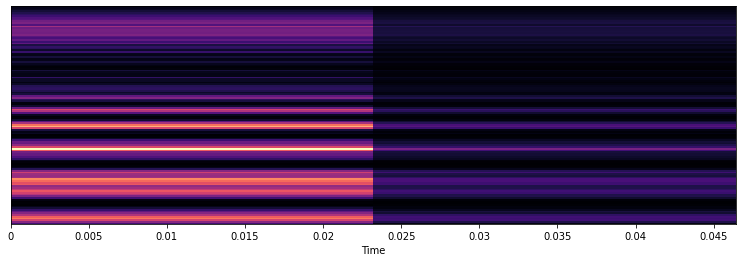

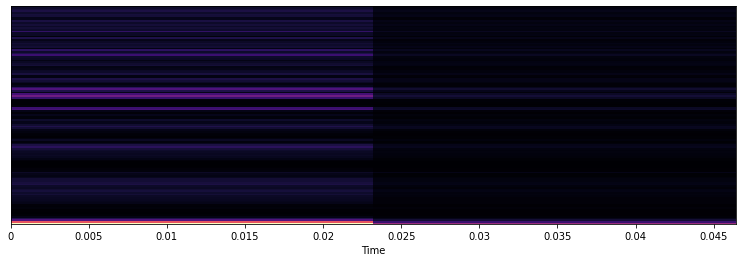

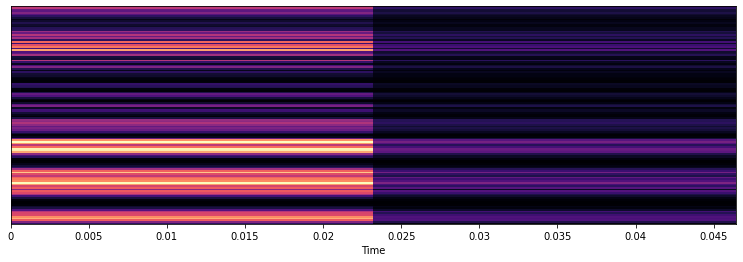

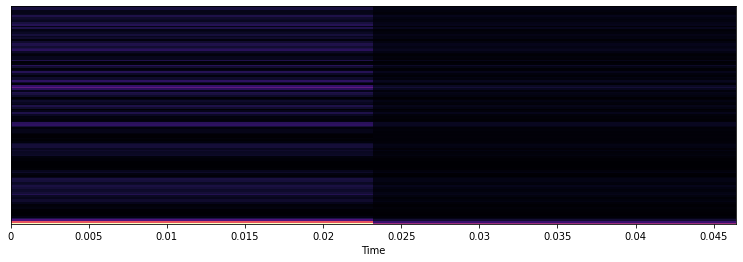

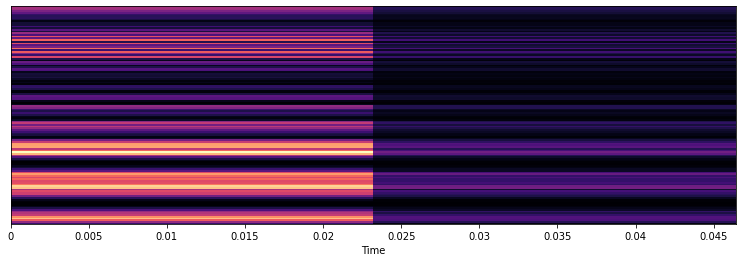

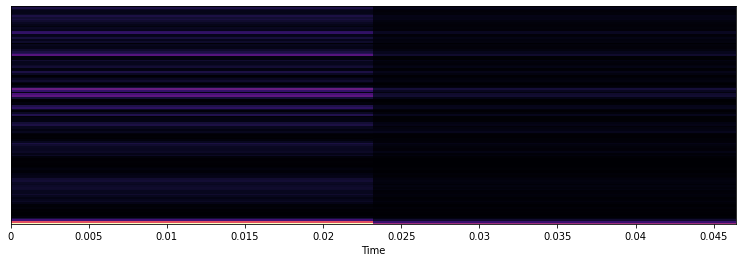

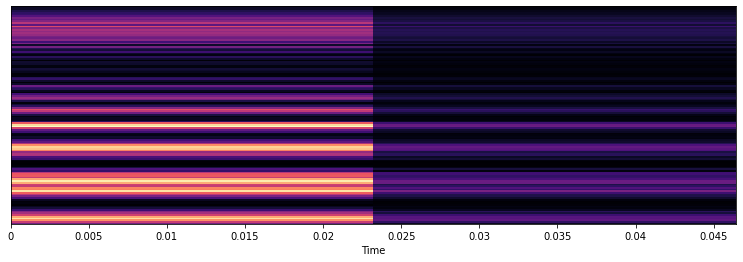

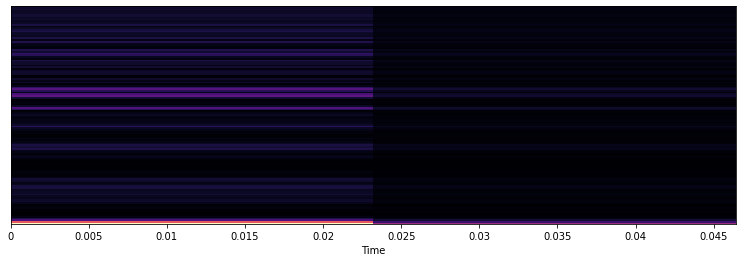

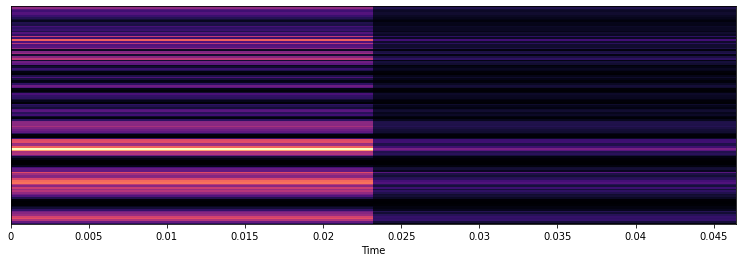

In [53]:
### EXEMPLE OF TRANSFORMED SAMPLE (30 DIFFERENT PRESSURE SIGNALS) ###

for i in range(30):
    plt.figure(figsize=(13, 4))
    librosa.display.specshow(df_spectre[20][:,:,i], x_axis='time')

In [0]:
### TRAIN TEST SPLIT ###

X_train, X_test, y_train, y_test = train_test_split(df_spectre, y, random_state = 42, test_size=0.2)

In [0]:
### DEFINE CRNN ###

def get_model(data):
    
    inp = Input(shape=(data.shape[1], data.shape[2], data.shape[3]))
    
    x = Conv2D(filters = 64, kernel_size=(2, 2), padding='same')(inp)
    
    x = Permute((2, 3, 1))(x)
    x = BatchNormalization(axis=-1)(x)
    x = Permute((3, 1, 2))(x)
    # equal to BatchNormalization(axis=1)
    
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 1))(x)
    x = Dropout(0.2)(x)
    
    x = Permute((2, 3, 1))(x)
    x = Reshape((data.shape[2], 64*64))(x)

    x = Bidirectional(GRU(64, activation='relu', return_sequences=False))(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(y_train.shape[1], activation='softmax')(x)
    
    model = Model(inputs=inp, outputs=out)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [56]:
model = get_model(X_train)

model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128, 2, 30)]      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 2, 64)        7744      
_________________________________________________________________
permute_18 (Permute)         (None, 2, 64, 128)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 2, 64, 128)        512       
_________________________________________________________________
permute_19 (Permute)         (None, 128, 2, 64)        0         
_________________________________________________________________
activation_6 (Activation)    (None, 128, 2, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 2, 64)         0   

In [57]:
es = EarlyStopping(monitor='val_accuracy', mode='auto', restore_best_weights=True, verbose=1, patience=15)

model = get_model(X_train)
model.fit(X_train, y_train, epochs=100, batch_size=256, verbose=2, validation_split=0.1, callbacks=[es])

Epoch 1/100
1/1 - 0s - loss: 0.8722 - accuracy: 0.4379 - val_loss: 12.4565 - val_accuracy: 0.7895
Epoch 2/100
1/1 - 0s - loss: 0.8937 - accuracy: 0.8817 - val_loss: 5.3188 - val_accuracy: 0.7895
Epoch 3/100
1/1 - 0s - loss: 0.7134 - accuracy: 0.7870 - val_loss: 0.7686 - val_accuracy: 0.7895
Epoch 4/100
1/1 - 0s - loss: 0.4889 - accuracy: 0.7751 - val_loss: 1.4542 - val_accuracy: 0.7895
Epoch 5/100
1/1 - 0s - loss: 0.3859 - accuracy: 0.8698 - val_loss: 1.8094 - val_accuracy: 0.7895
Epoch 6/100
1/1 - 0s - loss: 0.3454 - accuracy: 0.8817 - val_loss: 1.5241 - val_accuracy: 0.7895
Epoch 7/100
1/1 - 0s - loss: 0.3647 - accuracy: 0.8817 - val_loss: 1.4527 - val_accuracy: 0.7895
Epoch 8/100
1/1 - 0s - loss: 0.3754 - accuracy: 0.8817 - val_loss: 1.2994 - val_accuracy: 0.7895
Epoch 9/100
1/1 - 0s - loss: 0.3454 - accuracy: 0.8817 - val_loss: 1.2177 - val_accuracy: 0.7895
Epoch 10/100
1/1 - 0s - loss: 0.3348 - accuracy: 0.8817 - val_loss: 1.0491 - val_accuracy: 0.7895
Epoch 11/100
1/1 - 0s - loss

In [0]:
### GET PREDICTED CLASS ###

pred_test = np.argmax(model.predict(X_test), axis=1)

In [59]:
print(classification_report([diz_reverse_label[np.argmax(label)] for label in y_test], 
                            [diz_reverse_label[label] for label in pred_test]))

              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93        41
         1.0       0.00      0.00      0.00         6

    accuracy                           0.87        47
   macro avg       0.44      0.50      0.47        47
weighted avg       0.76      0.87      0.81        47



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


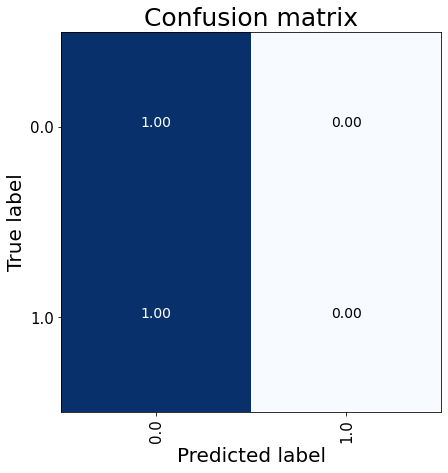

In [60]:
cnf_matrix = confusion_matrix([diz_reverse_label[np.argmax(label)] for label in y_test], 
                              [diz_reverse_label[label] for label in pred_test])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(diz_reverse_label.values()))
plt.show()